In [2]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import numpy as np
import matplotlib.pyplot as plt
import moment as m
from scipy.optimize import curve_fit

In [3]:
hdul = fits.open('/Users/simonsmith/Documents/SURP/HC2/HC2_HC5N_all_rebase3_trim.fits')
head = hdul[0].header
data = hdul[0].data

In [4]:
x_pix, y_pix, z_pix = head['NAXIS1'], head['NAXIS2'], head['NAXIS3']
x_deg, y_deg = x_pix*head['CDELT1']*u.deg, y_pix*head['CDELT2']*u.deg

x_pc, y_pc = (x_deg.to(u.rad)*140*u.pc)/u.rad, (y_deg.to(u.rad)*140*u.pc)/u.rad
x_au, y_au = x_pc.to(u.au), y_pc.to(u.au)

d_freq = head['CDELT3']*u.Hz
d_v = (c.c*(d_freq/(head['RESTFRQ']*u.Hz))).to(u.m/u.s)

rad_v = []
freqs = []
for i in range(z_pix):
    freq = head['CRVAL3']*u.Hz - (i-head['CRPIX3'])*d_freq
    freqs.append(freq/u.Hz)
    rad_v.append((c.c*(1 - freq/(head['RESTFRQ']*u.Hz))).to(u.m/u.s)/(u.m/u.s))
    
rad_v = np.asarray(rad_v)
freqs = np.asarray(freqs)

def gauss(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

In [5]:
spec = m.int_pix(data, 60, 180)


In [6]:
#Based on Frequency
init_vals = [np.max(spec), freqs[np.where(spec == np.max(spec))[0][0]], 1e9]  # for [amp, cen, wid]
best_vals, covar = curve_fit(gauss, freqs, spec, p0=init_vals)
print('best_vals: {}'.format(best_vals))

best_vals: [2.21791099e+00 2.39634297e+10 3.46194663e+08]


In [7]:
#Based on Velocity
init_vals1 = [np.max(spec), rad_v[np.where(spec == np.max(spec))[0][0]], 1e5]  # for [amp, cen, wid]
best_vals1, covar1 = curve_fit(gauss, rad_v, spec, p0=init_vals1)
print('best_vals: {}'.format(best_vals1))

best_vals: [2.21776571e+00 5.89654122e+03 5.41932324e+04]


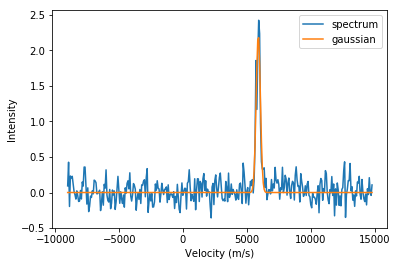

The column density is: 915.089, the mean velocity is: 5896.541 m / s, the velocity dispersion is: 164.610 m / s


In [34]:
spec = m.int_pix(data, 60, 180)
plt.plot(rad_v, spec, label='spectrum')
amp, cen, wid = best_vals1
plt.plot(rad_v, gauss(rad_v, best_vals1[0], best_vals1[1], best_vals1[2]), label='gaussian')
plt.legend()
plt.ylabel('Intensity')
plt.xlabel('Velocity (m/s)')
plt.show()

density = amp*np.sqrt(np.pi*wid)
mean = cen*u.m/u.s
dispersion = np.sqrt(wid/2)*u.m/u.s

print("The column density is: {0:.3f}, the mean velocity is: {1:.3f}, the velocity dispersion is: {2:.3f}".format(density, mean, dispersion))

best_vals: [1.15291856e+00 5.02699805e+03 6.60016106e+02]


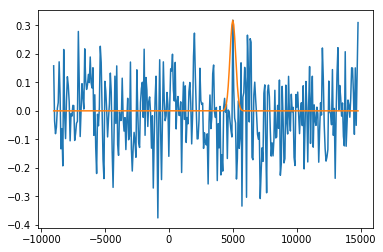

In [10]:
spec2 = m.int_pix(data, 62, 160)
plt.plot(rad_v, spec2)
plt.plot(rad_v, gauss(rad_v, np.max(spec2), rad_v[np.where(spec2 == np.max(spec2))[0][0]], 1e5))

init_vals2 = [np.max(spec2), rad_v[np.where(spec2 == np.max(spec2))[0][0]], 1e5]  # for [amp, cen, wid]
best_vals2, covar2 = curve_fit(gauss, rad_v, spec2, p0=init_vals2)
print('best_vals: {}'.format(best_vals2))

#plt.plot(rad_v, gauss(rad_v, best_vals2[0], best_vals2[1], best_vals2[2]), label='gaussian')
plt.show()



In [11]:
np.where(spec == np.max(spec))[0][0]

209

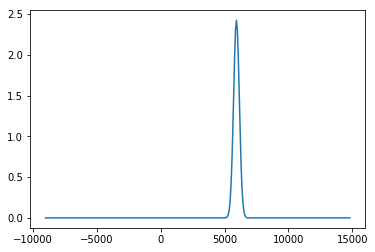

In [12]:
plt.plot(rad_v, gauss(rad_v, np.max(spec), rad_v[np.where(spec == np.max(spec))[0][0]], 1e5))

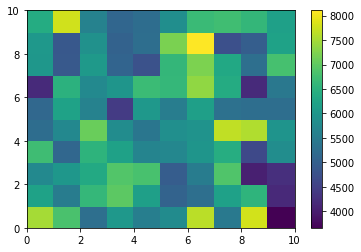

array([-2.04428003e-01, -2.58234278e-02, -1.61028046e-02,  5.00034404e-02,
        1.27541761e-01, -5.77040536e-02, -1.29754021e-01, -2.68561874e-01,
        1.36385921e-01, -5.34598924e-02,  8.54593187e-02,  4.14866038e-02,
        2.67084238e-02,  7.95566131e-02,  2.33628012e-02,  1.27919655e-01,
        1.21828768e-01, -1.24825255e-01, -1.49232514e-01,  1.91551257e-01,
       -1.45685136e-01, -2.64857464e-02,  1.99687108e-01, -5.84268188e-02,
       -5.26482956e-02, -1.23700542e-01,  1.20850054e-01,  8.04640336e-02,
       -2.35660512e-01,  2.04415251e-01, -4.20219871e-03, -1.06961778e-01,
        4.61062830e-02,  1.29916556e-02, -1.93718352e-02,  1.93356748e-01,
       -5.90333430e-02, -1.94968504e-01, -8.67356331e-02,  4.57489604e-02,
        1.93706682e-01,  1.15561776e-01,  1.32449278e-01,  1.34534310e-01,
       -1.10347242e-01,  1.44415981e-02, -6.40087741e-02, -7.44014371e-02,
        4.46549983e-02, -6.43496926e-02, -1.96247917e-01,  1.53588474e-01,
        4.54541433e-02, -

In [29]:
subset = data.T[55:65, 165:175].T

plt.pcolormesh(m.first(subset, rad_v))
plt.colorbar()
plt.show()

subset.shape

sub_spec = m.int_pix(subset, 2, 3)

sub_spec

In [22]:
def fit_g(data, rad_v):    
    
    col_dens = np.zeros((data.T.shape[0], data.T.shape[1]))
    vel = np.zeros((data.T.shape[0], data.T.shape[1]))
    dis_vel = np.zeros((data.T.shape[0], data.T.shape[1]))


    for i in range(data.T.shape[0]):  
        for j in range(data.T.shape[1]):

            sub_spec = m.int_pix(data.T, i, j)
            if sub_spec[0] == np.nan:

                density = np.nan
                mean = np.nan
                dispersion = np.nan
            else:
                init_vals = [np.max(sub_spec), rad_v[np.where(sub_spec == np.max(sub_spec))[0][0]], 1e5]  # for [amp, cen, wid]
                best_vals, covar = curve_fit(gauss, rad_v, sub_spec, p0=init_vals)

                density = best_vals[0]*np.sqrt(np.pi*best_vals[2])
                mean = best_vals[1]
                dispersion = np.sqrt(best_vals[2]/2)


            col_dens[i][j] = density
            vel[i][j] = mean
            dis_vel[i][j] = dispersion

    col_dens = col_dens.T
    vel = vel.T
    dis_vel = dis_vel.T
    
    return col_dens, vel, dis_vel


In [25]:
col_dens, vel, dis_vel = fit_g(subset)

ValueError: operands could not be broadcast together with shapes (334,) (10,) 

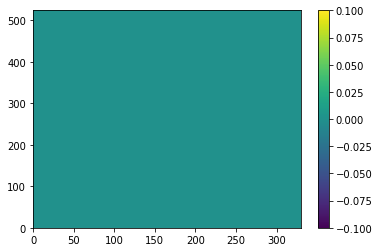

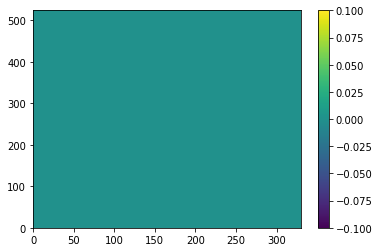

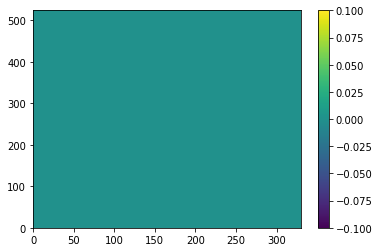

In [16]:
plt.pcolormesh(col_dens)
plt.colorbar()
plt.show()
plt.pcolormesh(vel)
plt.colorbar()
plt.show()
plt.pcolormesh(dis_vel)
plt.colorbar()
plt.show()

In [21]:
col_dens

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])